In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Define standard total uncertainty
u = 0.5 / 12
u_squared = u**2
print(f"Standard total uncertainty (u): {u:.4f} ft, u^2: {u_squared:.6f} ft^2")

# Read all CSV files in the pitch-data folder
N20 = pd.read_csv('pitch-data/N20pitch.txt', names=['time', 'x', 'y', 'z'], sep="\t", header=0)
N100 = pd.read_csv('pitch-data/N100pitch.txt', names=['time', 'x', 'y', 'z'], sep="\t", header=0)
N300 = pd.read_csv('pitch-data/N300pitch.txt', names=['time', 'x', 'y', 'z'], sep="\t", header=0)
N1000 = pd.read_csv('pitch-data/N1000pitch.txt', names=['time', 'x', 'y', 'z'], sep="\t", header=0)

Standard total uncertainty (u): 0.0417 ft, u^2: 0.001736 ft^2


In [2]:
# Polynomial fit function
def poly_fit_2nd_order(x, y, u_squared):
    # Prepare the data
    num_points = len(x)
    x_vec = np.array(x)
    y_vec = np.array(y)
    ones = np.ones(num_points)
    x_squared = x_vec**2
    x_cubed = x_vec**3
    x_quad = x_vec**4

    # Calculate sums
    s_one_u2 = np.sum(ones / u_squared)
    s_x_u2 = np.sum(x_vec / u_squared)
    s_x2_u2 = np.sum(x_squared / u_squared)
    s_x3_u2 = np.sum(x_cubed / u_squared)
    s_x4_u2 = np.sum(x_quad / u_squared)
    s_y_u2 = np.sum(y_vec / u_squared)
    s_yx_u2 = np.sum(y_vec * x_vec / u_squared)
    s_yx2_u2 = np.sum(y_vec * x_squared / u_squared)

    # Construct matrices
    Delta_matrix = np.array([[s_one_u2, s_x_u2, s_x2_u2],
                      [s_x_u2, s_x2_u2, s_x3_u2],
                      [s_x2_u2, s_x3_u2, s_x4_u2]])
    A_1_matrix = np.array([[s_y_u2, s_x_u2, s_x2_u2],
                           [s_yx_u2, s_x2_u2, s_x3_u2],
                           [s_yx2_u2, s_x3_u2, s_x4_u2]])
    A_2_matrix = np.array([[s_one_u2, s_y_u2, s_x2_u2],
                           [s_x_u2, s_yx_u2, s_x3_u2],
                           [s_x2_u2, s_yx2_u2, s_x4_u2]])
    A_3_matrix = np.array([[s_one_u2, s_x_u2, s_y_u2],
                           [s_x_u2, s_x2_u2, s_yx_u2],
                           [s_x2_u2, s_x3_u2, s_yx2_u2]])
    Delta = np.linalg.det(Delta_matrix)
    A_1 = 1 / Delta * np.linalg.det(A_1_matrix)
    A_2 = 1 / Delta * np.linalg.det(A_2_matrix)
    A_3 = 1 / Delta * np.linalg.det(A_3_matrix)

    coeffs = np.array([A_3, A_2, A_1])
    return coeffs

# Calculate polynomial coefficient uncertainties
def fit_uncertainties(x, u_squared):
    num_points = len(x)
    x_vec = np.array(x)

    # Construct alpha matrix
    alpha = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    for i in range(3):
        for j in range(3):
            sum = 0
            for k in range(num_points):
                val = (x_vec[k]**i) * (x_vec[k]**j) / u_squared
                sum += val
            alpha[i][j] = sum
    alpha = np.array(alpha)
    epsilon = np.linalg.inv(alpha)
    u_A1 = np.sqrt(epsilon[0, 0])
    u_A2 = np.sqrt(epsilon[1, 1])
    u_A3 = np.sqrt(epsilon[2, 2])

    # Print the alpha and epsilon matrices
    print(f"Alpha:\n{alpha}")
    print(f"\nEpsilon:\n{epsilon}")

    uncertainties = np.array([u_A3, u_A2, u_A1])
    return uncertainties

In [3]:
# Function to fit and plot a 2nd order polynomial using custom polyfit
def fit_and_plot(data, directions, title, u_squared):
    x = data['time']
    y_vals = []
    y_fits = []
    coeff_vals = []
    s_vals = []

    # Get default color cycle and use one color per direction
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Calculate uncertainties once
    uncerts = fit_uncertainties(x, u_squared)
    print(f"\nUncertainties: u_A1 = {uncerts[2]:.4f}, u_A2 = {uncerts[1]:.4f}, u_A3 = {uncerts[0]:.4f}")
    print("\nFits: i = A1 + A2*t + A3*t^2")

    for direction in directions:
        y = data[direction]
        y_vals.append(y)

        # Fit a 2nd order polynomial
        coeffs = poly_fit_2nd_order(x, y, u_squared)
        poly = np.poly1d(coeffs)
        coeff_vals.append(coeffs)

        # Generate x values for the fitted curve (same density as original)
        y_fit = poly(x)
        y_fits.append(y_fit)

        # Print results
        print(f"{direction} = {coeffs[2]:.4f} + {coeffs[1]:.4f}t + {coeffs[0]:.4f}t^2")

    # Print relative uncertainties
    print("\nRelative Uncertainties:")
    for i, direction in enumerate(directions):
        coeffs = coeff_vals[i]
        rel_u_A1 = uncerts[2] / abs(coeffs[2]) if coeffs[2] != 0 else float('inf')
        rel_u_A2 = uncerts[1] / abs(coeffs[1]) if coeffs[1] != 0 else float('inf')
        rel_u_A3 = uncerts[0] / abs(coeffs[0]) if coeffs[0] != 0 else float('inf')
        print(f"{direction}: u_A1/A1 = {rel_u_A1:.4%}, u_A2/A2 = {rel_u_A2:.4%}, u_A3/A3 = {rel_u_A3:.4%}")

    print("\ns^2 values:")
    for i, direction in enumerate(directions):
        actual = y_vals[i]
        fitted = y_fits[i]
        residuals = actual - fitted
        s_val = np.sum(residuals**2) / (len(x) - 3)
        s_vals.append(s_val)
        print(f"{direction}: s^2 = {s_val:.4f}")

    # Plot original data and fitted curve
    plt.figure(figsize=(10, 12))
    for i, dir in enumerate(directions):
        color = colors[i % len(colors)]
        plt.errorbar(x, y_vals[i], yerr=np.sqrt(u_squared), fmt='o', color=color, label=f'Original Data - {dir.upper()}', markersize=2, capsize=0, capthick=1, elinewidth=1)
        plt.plot(x, y_fits[i], color=color, label=f'Fitted Curve - {dir.upper()}', linewidth=1)
    plt.title(f'{title} Pitch Data with 2nd Order Polynomial Fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (ft.)')
    plt.legend()
    plt.show()

    return coeff_vals, uncerts

In [4]:
# Comparing manual fit with NumPy's polyfit
coefficients = poly_fit_2nd_order(N20['time'], N20['x'], u_squared)
coeffs = np.polyfit(N20['time'], N20['x'], 2)
print(f"\nManual coefficients: y = {coefficients[2]:.4f} + {coefficients[1]:.4f}x + {coefficients[0]:.4f}x^2")
print(f"NumPy coefficients: y = {coeffs[2]:.4f} + {coeffs[1]:.4f}x + {coeffs[0]:.4f}x^2")


Manual coefficients: y = 0.5228 + -1.1974x + 2.8787x^2
NumPy coefficients: y = 0.5228 + -1.1974x + 2.8787x^2


Alpha:
[[11520.       2736.        889.2    ]
 [ 2736.        889.2       324.9    ]
 [  889.2       324.9       126.59985]]

Epsilon:
[[ 0.00064371 -0.00527597  0.00901876]
 [-0.00527597  0.06129592 -0.12025012]
 [ 0.00901876 -0.12025012  0.25315815]]

Uncertainties: u_A1 = 0.0254, u_A2 = 0.2476, u_A3 = 0.5031

Fits: i = A1 + A2*t + A3*t^2
x = 0.5228 + -1.1974t + 2.8787t^2
y = 54.1385 + -107.3560t + 7.1518t^2
z = 6.2056 + -0.2005t + -20.1755t^2

Relative Uncertainties:
x: u_A1/A1 = 4.8529%, u_A2/A2 = 20.6773%, u_A3/A3 = 17.4786%
y: u_A1/A1 = 0.0469%, u_A2/A2 = 0.2306%, u_A3/A3 = 7.0352%
z: u_A1/A1 = 0.4089%, u_A2/A2 = 123.4974%, u_A3/A3 = 2.4939%

s^2 values:
x: s^2 = 0.0014
y: s^2 = 0.0012
z: s^2 = 0.0022


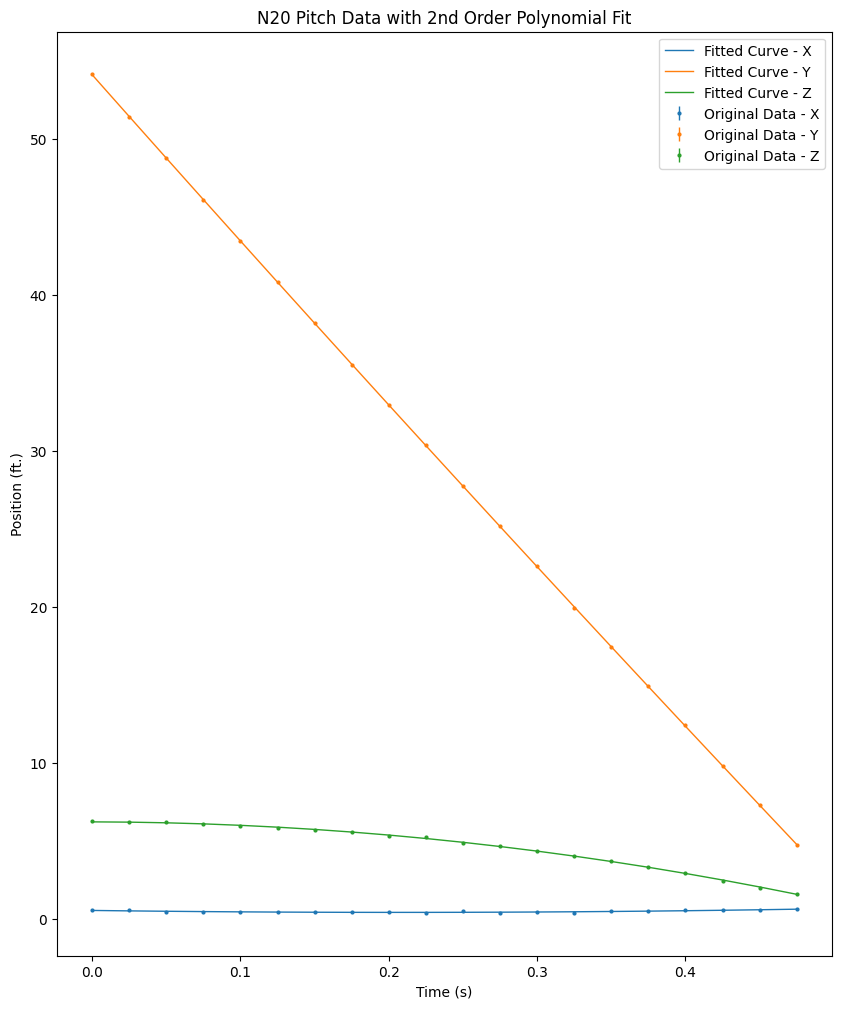

In [5]:
all_directions = ['x', 'y', 'z']
N20_coeffs, N20_uncerts = fit_and_plot(N20, all_directions, 'N20', u_squared)

Alpha:
[[57600.        14256.         4728.24     ]
 [14256.         4728.24       1764.18     ]
 [ 4728.24       1764.18        702.1199988]]

Epsilon:
[[ 0.00015016 -0.00120729  0.00202226]
 [-0.00120729  0.01309079 -0.02476238]
 [ 0.00202226 -0.02476238  0.05002501]]

Uncertainties: u_A1 = 0.0123, u_A2 = 0.1144, u_A3 = 0.2237

Fits: i = A1 + A2*t + A3*t^2
x = 0.4788 + -0.8376t + 2.1905t^2
y = 54.1259 + -107.3051t + 6.9758t^2
z = 6.2077 + -0.4104t + -19.7456t^2

Relative Uncertainties:
x: u_A1/A1 = 2.5593%, u_A2/A2 = 13.6599%, u_A3/A3 = 10.2105%
y: u_A1/A1 = 0.0226%, u_A2/A2 = 0.1066%, u_A3/A3 = 3.2063%
z: u_A1/A1 = 0.1974%, u_A2/A2 = 27.8788%, u_A3/A3 = 1.1327%

s^2 values:
x: s^2 = 0.0019
y: s^2 = 0.0017
z: s^2 = 0.0021


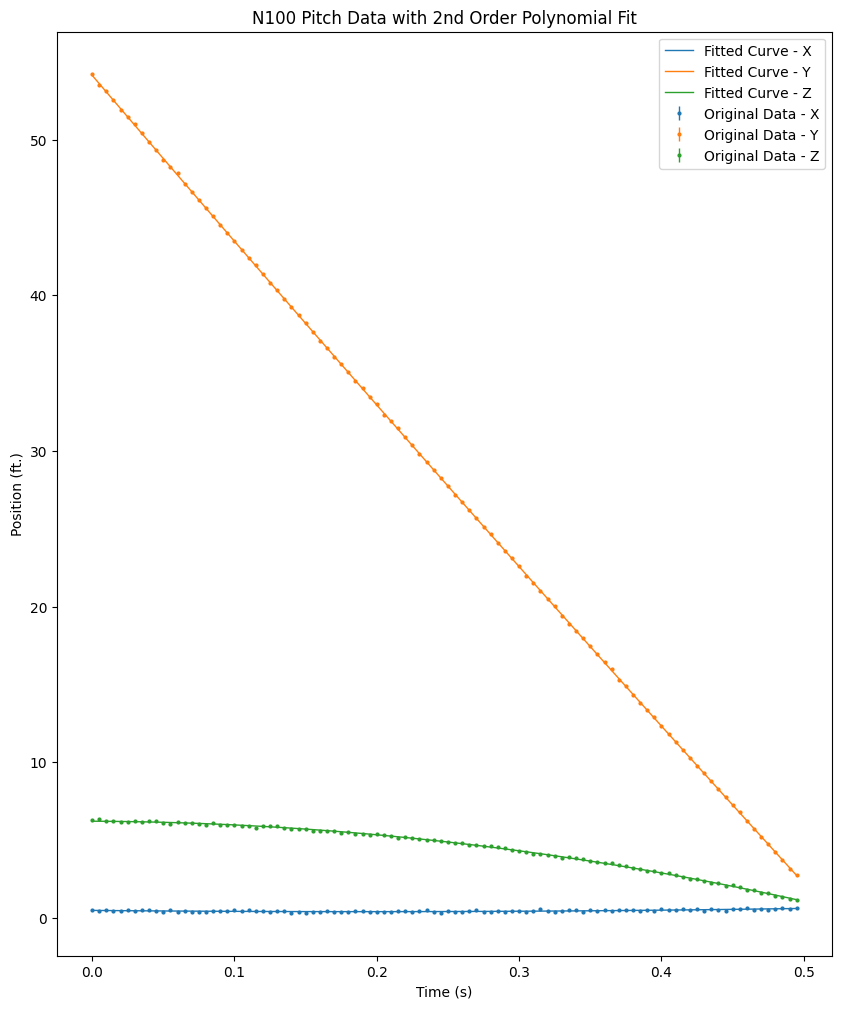

In [6]:
N100_coeffs, N100_uncerts = fit_and_plot(N100, all_directions, 'N100', u_squared)

Alpha:
[[172800.          43056.          14328.07993601]
 [ 43056.          14328.07993601   5364.05995201]
 [ 14328.07993601   5364.05995201   2142.03996796]]

Epsilon:
[[ 5.13950191e-05 -4.11844659e-04  6.87553696e-04]
 [-4.11844659e-04  4.41694637e-03 -8.30601773e-03]
 [ 6.87553696e-04 -8.30601773e-03  1.66675941e-02]]

Uncertainties: u_A1 = 0.0072, u_A2 = 0.0665, u_A3 = 0.1291

Fits: i = A1 + A2*t + A3*t^2
x = 0.4918 + -0.9208t + 2.3560t^2
y = 54.1461 + -107.3712t + 6.9547t^2
z = 6.2033 + -0.2718t + -20.0696t^2

Relative Uncertainties:
x: u_A1/A1 = 1.4578%, u_A2/A2 = 7.2173%, u_A3/A3 = 5.4797%
y: u_A1/A1 = 0.0132%, u_A2/A2 = 0.0619%, u_A3/A3 = 1.8563%
z: u_A1/A1 = 0.1156%, u_A2/A2 = 24.4487%, u_A3/A3 = 0.6433%

s^2 values:
x: s^2 = 0.0019
y: s^2 = 0.0014
z: s^2 = 0.0024


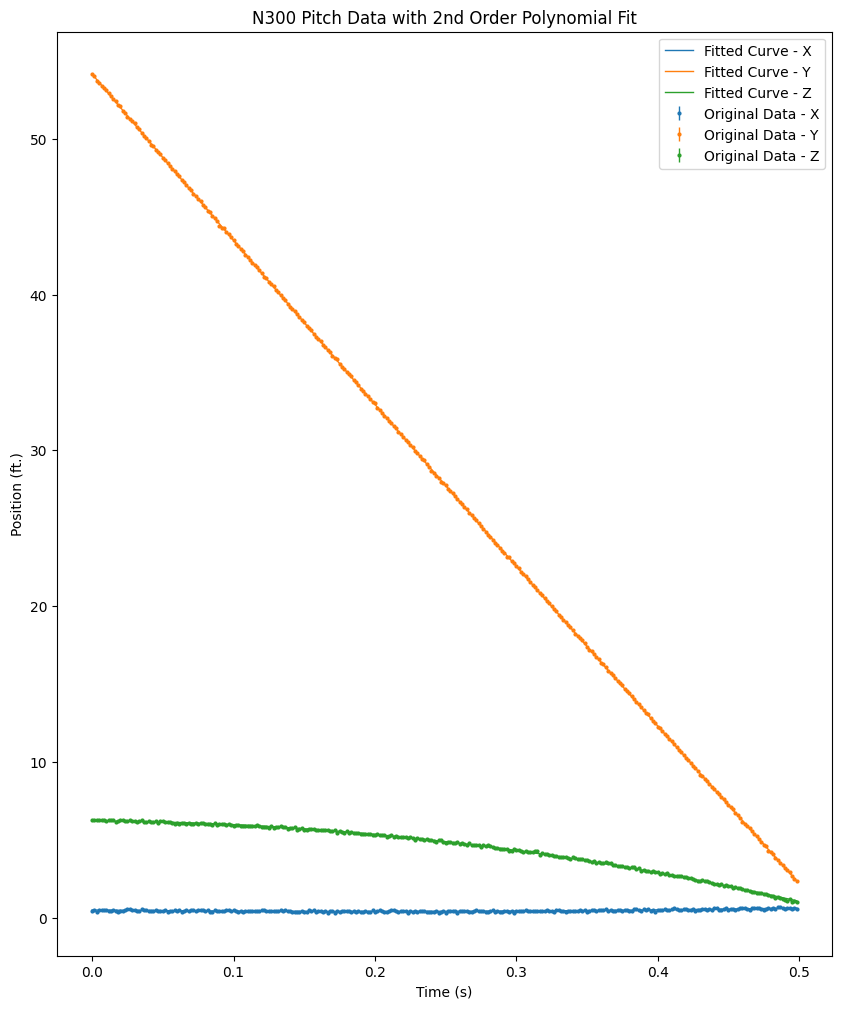

In [7]:
N300_coeffs, N300_uncerts = fit_and_plot(N300, all_directions, 'N300', u_squared)

Alpha:
[[576000.    143856.     47928.024]
 [143856.     47928.024  17964.018]
 [ 47928.024  17964.018   7182.012]]

Epsilon:
[[ 1.55626663e-05 -1.24563560e-04  2.07709789e-04]
 [-1.24563560e-04  1.33084090e-03 -2.49751249e-03]
 [ 2.07709789e-04 -2.49751249e-03  5.00002500e-03]]

Uncertainties: u_A1 = 0.0039, u_A2 = 0.0365, u_A3 = 0.0707

Fits: i = A1 + A2*t + A3*t^2
x = 0.4937 + -0.9674t + 2.4283t^2
y = 54.1324 + -107.2821t + 6.8334t^2
z = 6.1994 + -0.2281t + -20.1971t^2

Relative Uncertainties:
x: u_A1/A1 = 0.7991%, u_A2/A2 = 3.7711%, u_A3/A3 = 2.9119%
y: u_A1/A1 = 0.0073%, u_A2/A2 = 0.0340%, u_A3/A3 = 1.0348%
z: u_A1/A1 = 0.0636%, u_A2/A2 = 15.9936%, u_A3/A3 = 0.3501%

s^2 values:
x: s^2 = 0.0017
y: s^2 = 0.0018
z: s^2 = 0.0023


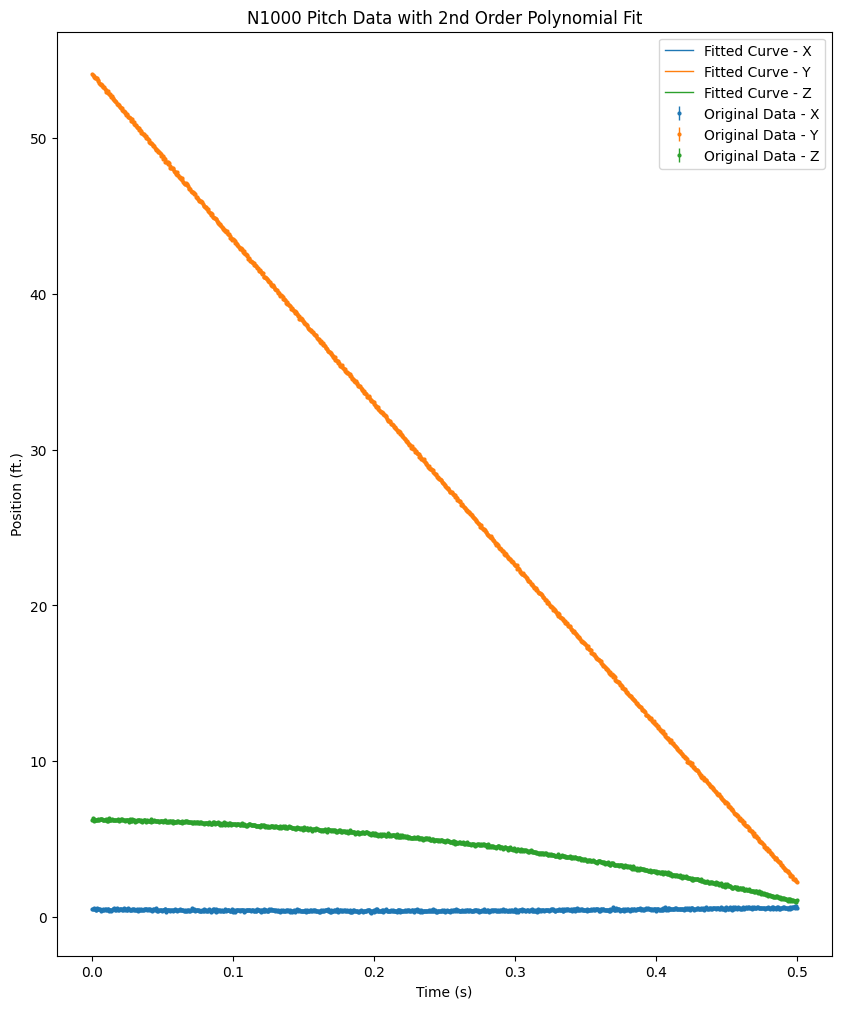

In [8]:
N1000_coeffs, N1000_uncerts = fit_and_plot(N1000, all_directions, 'N1000', u_squared)

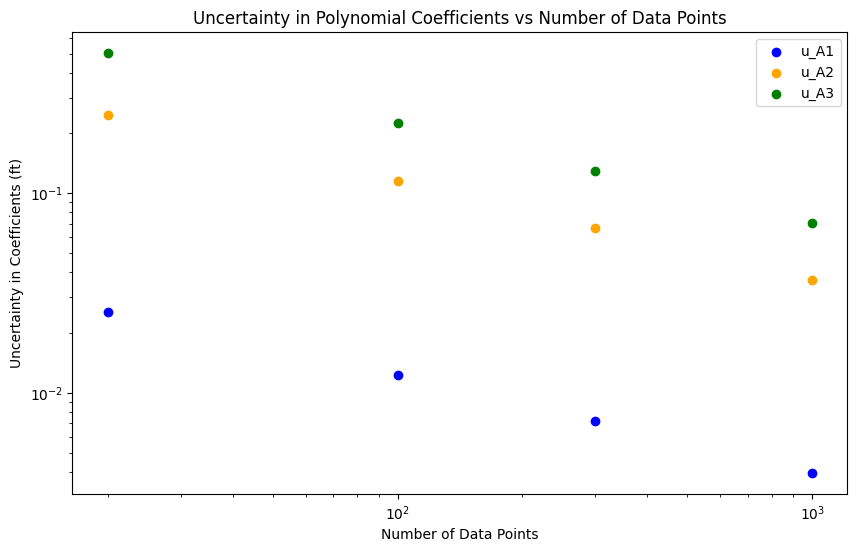

In [14]:
n_points = [20, 100, 300, 1000]
A1_uncertainties = [N20_uncerts[2], N100_uncerts[2], N300_uncerts[2], N1000_uncerts[2]]
A2_uncertainties = [N20_uncerts[1], N100_uncerts[1], N300_uncerts[1], N1000_uncerts[1]]
A3_uncertainties = [N20_uncerts[0], N100_uncerts[0], N300_uncerts[0], N1000_uncerts[0]]
plt.figure(figsize=(10, 6))
plt.scatter(n_points, A1_uncertainties, label='u_A1', color='blue')
plt.scatter(n_points, A2_uncertainties, label='u_A2', color='orange')
plt.scatter(n_points, A3_uncertainties, label='u_A3', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Data Points')
plt.ylabel('Uncertainty in Coefficients (ft)')
plt.title('Uncertainty in Polynomial Coefficients vs Number of Data Points')
plt.legend()
plt.show()

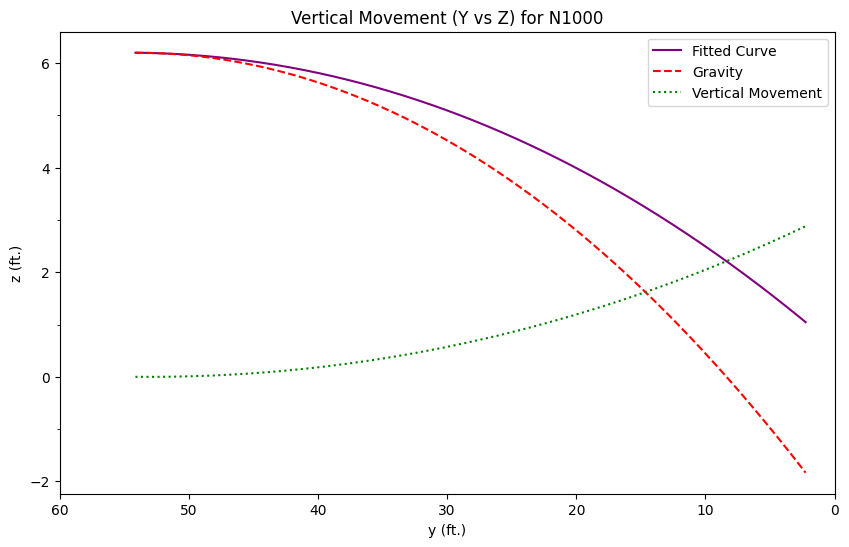

In [10]:
# Plot fits of y vs z for N1000
y_coefficients = N1000_coeffs[1]
z_coefficients = N1000_coeffs[2]
t = N1000['time']
y_fit = y_coefficients[0] * t**2 + y_coefficients[1] * t + y_coefficients[2]
z_fit = z_coefficients[0] * t**2 + z_coefficients[1] * t + z_coefficients[2]
z_gravity = -32.2 * t**2 + z_coefficients[2]
z_movement = z_fit - z_gravity
plt.figure(figsize=(10, 6))
plt.plot(y_fit, z_fit, label='Fitted Curve', color='purple')
plt.plot(y_fit, z_gravity, label='Gravity', color='red', linestyle='--')
plt.plot(y_fit, z_movement, label='Vertical Movement', color='green', linestyle=':')
plt.legend()
plt.xlabel('y (ft.)')
plt.ylabel('z (ft.)')
plt.xlim(60, 0)
plt.gca().yaxis.set_major_locator(MultipleLocator(2))
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.title('Vertical Movement (Y vs Z) for N1000')
plt.show()


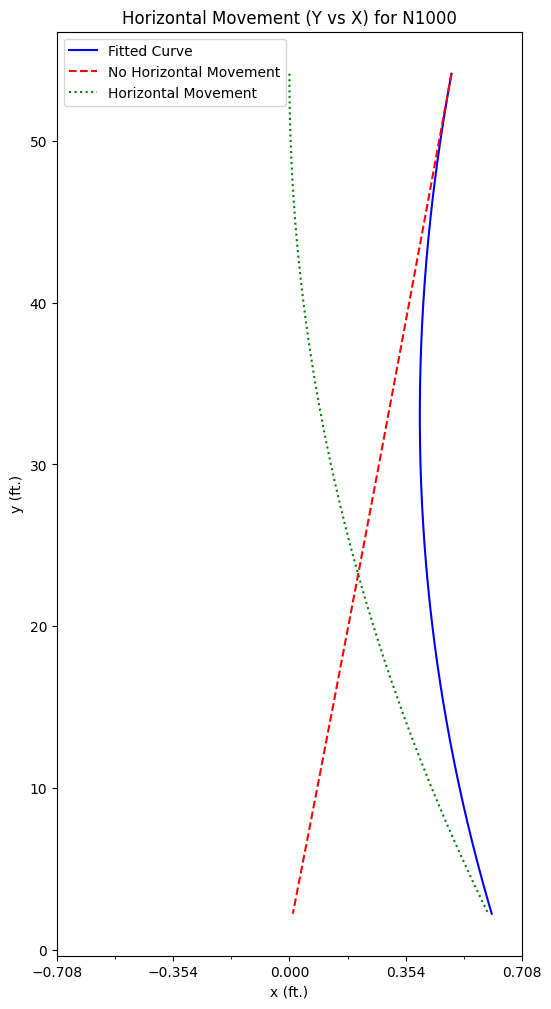

In [11]:
# Plot fits of y vs x for N1000
x_coefficients = N1000_coeffs[0]
x_fit = x_coefficients[0] * t**2 + x_coefficients[1] * t + x_coefficients[2]
x_no_move = x_coefficients[1] * t + x_coefficients[2]
x_movement = x_fit - x_no_move
plt.figure(figsize=(6, 12))
plt.plot(x_fit, y_fit, label='Fitted Curve', color='blue')
plt.plot(x_no_move, y_fit, label='No Horizontal Movement', color='red', linestyle='--')
plt.plot(x_movement, y_fit, label='Horizontal Movement', color='green', linestyle=':')
plt.legend()
plt.xlabel('x (ft.)')
plt.ylabel('y (ft.)')
plt.xlim(-8.5/12,8.5/12)
plt.gca().xaxis.set_major_locator(MultipleLocator((8.5/12)/2))
plt.gca().xaxis.set_minor_locator(MultipleLocator((8.5/12)/4))
plt.title('Horizontal Movement (Y vs X) for N1000')
plt.show()

In [12]:
# Calculate the pitch velocity at t = 0 for N1000
v_ftps = np.sqrt(N1000_coeffs[0][1]**2 + N1000_coeffs[1][1]**2 + N1000_coeffs[2][1]**2)
v_mph = v_ftps * 3600 / 5280
print(f"Pitch velocity at t=0 for N1000: {v_ftps:.2f} ft/s ({v_mph:.2f} mph)")

Pitch velocity at t=0 for N1000: 107.29 ft/s (73.15 mph)
